In [32]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import cv2

In [33]:
def extraer_frames(video_path, frames_path, n_frames):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success and count < n_frames:
      cv2.imwrite(frames_path+"frame%d.jpg" % count, image)     # save frame as JPEG file      
      success,image = vidcap.read()
      print('Read a new frame: ', success)
      count += 1

video_path = "../../videos_fluidos/vel_hiperlenta_70frames.avi"
frames_path =  "../../frames_fluidos/frames_hiperlento/"
extraer_frames(video_path, frames_path, 10)


Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True


(696, 696) (696, 696)
(672, 672) (672, 672)


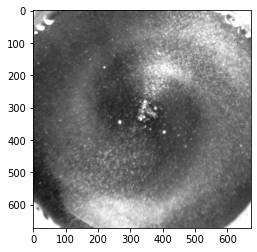

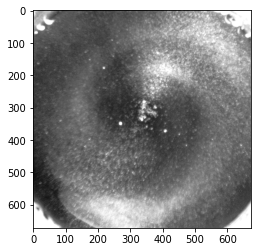

In [34]:
frame_a = tools.imread(frames_path+"frame0.jpg")
frame_b = tools.imread(frames_path+"frame1.jpg")
print(frame_a.shape, frame_b.shape)

frame_a = frame_a[12:-12, 12:-12]
frame_b = frame_b[12:-12, 12:-12]
print(frame_a.shape, frame_b.shape)
plt.imshow(frame_a, cmap="Greys_r")
plt.show()
plt.imshow(frame_b, cmap="Greys_r")
plt.show()


In [51]:
winsize = 32
searchsize = 40
fps = 70
dt = 1/fps
overlap=17


In [52]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [53]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

In [54]:
u1, v1, mask = validation.sig2noise_val(
    u0, v0,
    sig2noise,
    threshold = 1.05,
)



In [55]:
u2, v2 = filters.replace_outliers(
    u1, v1,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

In [56]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor = 96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [57]:
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

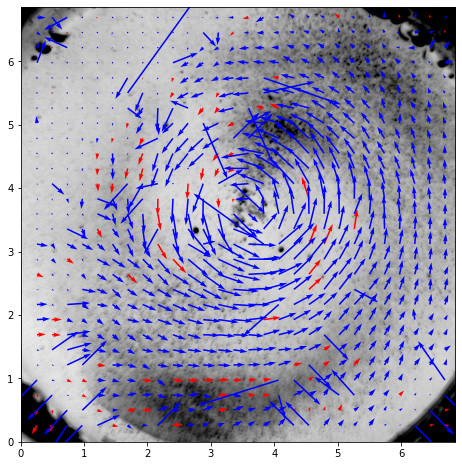

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    'exp1_001.txt',
    ax=ax, scaling_factor=96.52,
    scale=50, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name=frames_path+"frame0.jpg",
);